In [4]:
import deepSI
from deepSI import System_data, System_data_list
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
import os

from scipy.io import loadmat
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
from encoder_LPV_models import LPV_multi_encoder, LPV_single_encoder

In [6]:
#Remove exp_p
#3 Cases with 
# * Single use encoder
# * Multi measured encoder -> simulation with model output
# * Multi model    encoder -> simulation with model output
# - SS_encoder
# Sent data and bit of a figure.
# csv .mat
def loadsets(names, include_p=False):
    lis = []
    for n in names:
        out = loadmat(n)
        print(n)
        print(out.keys(),out['u_i2'].shape)
        u = np.concatenate([out['u_i2'],out['u_q1d'] if include_p else out['u_q1dref']],axis=1)
        y = out['y_q4d'][:,0]
        lis.append(deepSI.System_data(u=u,y=y))
    return deepSI.System_data_list(lis), out

m = './cdc2022-dllpvid-main/software/data/'

train_names = [m+i for i in os.listdir(m) if 'estim.' in i]
val_names = [m+i for i in os.listdir(m) if 'valid.' in i]
# train_names = ['data-roland/'+i for i in os.listdir('data-roland') if ('est' in i) and not ('4' in i)]
# val_names = ['data-roland/'+i for i in os.listdir('data-roland') if 'val' in i]
train, out = loadsets(train_names,include_p=True)
test, out = loadsets(val_names,include_p=True)
# val_frac = 0.10
# val = train[int(len(train)*(1-val_frac)):]
# train = train[:int(len(train)*(1-val_frac))]
# train, val, test

sys = LPV_multi_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10))
sys.init_model(train)
sys.apply_experiment(test[0][:1000])
sys.filter_experiment(test[0][:1000])
sys.fit(train,test,epochs=100000, loss_kwargs=dict(nf=60,loss_nf_cutoff=0.20**2),concurrent_val=True)


./cdc2022-dllpvid-main/software/data/ML_estim.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (10000, 1)
./cdc2022-dllpvid-main/software/data/ML_valid.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (30000, 1)
Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    1, sqrt loss  0.7943, Val sim-NRMS    nan, Time Loss: 89.7%, data: 6.3%, val: 4.0%,  0.0 vals/epoch, 201.6 batches/sec
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    2, sqrt loss  0.3676, Val sim-NRMS    nan, Time Loss: 90.7%, data: 6.1%, val: 3.2%,  0.0 vals/epoch, 211.7 batches/sec
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 Epoch    3, sqrt loss  0.4318, Val sim-NRMS    nan, Time Loss: 93.6%, data: 4.4%, val: 1.9%,  0.0 vals/epoch, 187.4 batches/sec
2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 2 2 3 2 2 2 2 3 3 3 3 3 3 2 3 3 3 3 3 3 Epoch    4, sqrt loss  0.2798, Val sim-NRMS    nan, Time Loss: 93.8%, data: 4.6%, val: 1.3%,  0.0 vals/epoch, 149.0 batches/sec
3 3 4 4 4 4 4 4 4 4 4 5 1 5 4 4 5 1 5 4 5 4 5 5 4 4 4 5 5 5 5 1 5 5 5 5 5 5 Epoch    5, sqrt loss  0.1797, Val sim-NRMS    nan, Time Loss: 95.4%, data: 3.6%, val: 0.8%,  0.0 vals/epoch

In [7]:
sys.save_system('LPV_multi-nx-5-Np-3-long-nf-60')

In [4]:
plt.figure(figsize=(16,5))
xlim = (0,10_000)
for i,traini in enumerate(train,start=1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    traini.plot()
for i,testi in enumerate(test,start=len(train)+1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    testi.plot()
plt.show()

plt.figure(figsize=(16,5))
for i,traini in enumerate(train,start=1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    plt.plot(traini.u)
for i,testi in enumerate(test,start=len(train)+1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    plt.plot(testi.u)
plt.show()



In [8]:
sys = LPV_single_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10))
sys.fit(train,test,epochs=100000, loss_kwargs=dict(nf=60,loss_nf_cutoff=0.20**2),concurrent_val=True)

Initilizing the model and optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    1, sqrt loss  0.7354, Val sim-NRMS    nan, Time Loss: 85.7%, data: 11.7%, val: 2.6%,  0.0 vals/epoch, 226.1 batches/sec
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    2, sqrt loss  0.3143, Val sim-NRMS    nan, Time Loss: 88.9%, data: 9.0%, val: 2.1%,  0.0 vals/epoch, 236.1 batches/sec
1 1 2 2 1 1 1 1 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 Epoch    3, sqrt loss  0.3913, Val sim-NRMS    nan, Time Loss: 91.0%, data: 7.2%, val: 1.7%,  0.0 vals/epoch, 213.6 batches/sec
2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 2 2 2 3 2 2 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 Epoch    4, sqrt loss  0.2217, Val sim-NRMS    nan, Time Loss: 92.1%, data: 6.2%, val: 1.7%,  0.0 vals/epoch, 185.7 batches/sec
3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 Epoch    5, sqrt loss  0.1886, Val sim-NRMS    nan, Time Loss: 93.1%, data: 5.6%, val: 1.3%,  0.0 vals/epoc

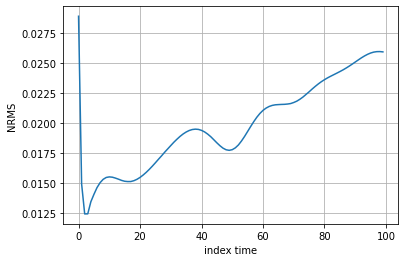

In [9]:
sys.n_step_error_plot(test[0])

In [10]:
sys.save_system('sys_LPV_single-nx-5-Np-3-nf-60V2')

In [11]:
sys_LPV_single = deepSI.load_system('sys_LPV_single-nx-5-Np-3-nf-60V2')
test_p = sys_LPV_single.apply_experiment(test)

In [16]:
test.plot()
(test_p - test).plot()
plt.legend(['test',f'test sim single use LPV {test_p.NRMS(test):.2%}'])
plt.show()
plt.plot(test.y[500:1000])
plt.plot(test_p.y[500:1000],'--r')
plt.legend(['test',f'test sim single use LPV {test_p.NRMS(test):.2%}'])
plt.show()



System_data of length: 1000 nu=2 ny=None normed=False dt=None

Initilizing the model and optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

BrokenPipeError: [WinError 109] The pipe has been ended

In [21]:
out = deepSI.fit_systems.grid_search(deepSI.fit_systems.SS_linear, sys_data=test[0],sys_dict_choices=dict(nx=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]), fit_dict_choices=dict(SS_f=[1,2,3,4,5,8,10,15,20,25,30,40,50,70,90,100]))
# sys = deepSI.fit_systems.SS_linear(nx=4)
# sys._fit(train[1])
# test_p = sys.apply_experiment(test)


1.0258274019161353 {'nx': 1} {'SS_f': 1}
0.9747702742510781 {'nx': 1} {'SS_f': 2}
0.8889629685092894 {'nx': 1} {'SS_f': 3}
0.9031006053384619 {'nx': 1} {'SS_f': 4}
0.9122934477009518 {'nx': 1} {'SS_f': 5}
0.9014870208600478 {'nx': 1} {'SS_f': 8}
0.9240750032901112 {'nx': 1} {'SS_f': 10}
0.8858259872006482 {'nx': 1} {'SS_f': 15}
1.0076077515950563 {'nx': 1} {'SS_f': 20}
1.0323522358450354 {'nx': 1} {'SS_f': 25}
733011.2173196969 {'nx': 1} {'SS_f': 30}
1.0166207319409977 {'nx': 1} {'SS_f': 40}
1.0126498362923262 {'nx': 1} {'SS_f': 50}
1.0077575696135639 {'nx': 1} {'SS_f': 70}
1.002047932381433 {'nx': 1} {'SS_f': 90}
1.0018218803748802 {'nx': 1} {'SS_f': 100}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0) for sys_dict= {'nx': 2} for fit_dict= {'SS_f': 1}
inf {'nx': 2} {'SS_f': 1}
0.9123589599775208 {'nx': 2} {'SS_f': 2}
0.925376976124379 {'nx': 2} {'SS_f': 3}
0.9046536829571077 {'nx': 2} 

D:\Programs\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


error Singular matrix for sys_dict= {'nx': 6} for fit_dict= {'SS_f': 20}
inf {'nx': 6} {'SS_f': 20}
0.8057258868572037 {'nx': 6} {'SS_f': 25}
0.6889025909338604 {'nx': 6} {'SS_f': 30}
0.8045095577065997 {'nx': 6} {'SS_f': 40}
0.7588332812633595 {'nx': 6} {'SS_f': 50}
0.7407578871014312 {'nx': 6} {'SS_f': 70}
0.7286217592307547 {'nx': 6} {'SS_f': 90}
0.7879458091111958 {'nx': 6} {'SS_f': 100}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (1,1) and (7,) not aligned: 1 (dim 1) != 7 (dim 0) for sys_dict= {'nx': 7} for fit_dict= {'SS_f': 1}
inf {'nx': 7} {'SS_f': 1}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (2,2) and (7,) not aligned: 2 (dim 1) != 7 (dim 0) for sys_dict= {'nx': 7} for fit_dict= {'SS_f': 2}
inf {'nx': 7} {'SS_f': 2}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (3,3) and (7,) not aligned: 3 (dim 1) != 7 (dim 0) for sy

In [22]:
sim_val, sysLTI, sys_d, fit_d = out

In [23]:
plt.plot(test.y)
plt.plot((sysLTI.apply_experiment(test)-test).y)
plt.show()

In [35]:
# sys = deepSI.fit_systems.SS_encoder(nx=6) #LPV_single_encoder(nx=8, na=5, nb=5)
#nx = 3 or 4?
#0.6399 for LTI
for l in sys.optimizer.state_dict()['param_groups']:
    l['lr'] = 0.0001
sys.fit(train, test[0], epochs=100000, loss_kwargs=dict(nf=150),concurrent_val=True)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  38.3 MB
N_training_samples = 9831, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch    1, sqrt loss  0.1058, Val sim-NRMS 0.1871, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    2, sqrt loss  0.5901, Val sim-NRMS  0.291, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    3, sqrt loss  0.6922, Val sim-NRMS 0.7584, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.1 batches/sec
Epoch    4, sqrt loss  0.4686, Val sim-NRMS 0.7359, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    5, sqrt loss  0.1578, Val sim-NRMS 0.5384, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    6, sqrt loss 0.09791, Val sim-NRMS 0.2697, Time Loss: 99.6%, data: 0.2%, val: 0.2%, 1.17 vals/epoch,  7.0 batches/sec
Epoch    7, sqrt loss 0.08087, Val sim-NRMS  0.215, Time Loss: 99.6%, data: 0.2%, val: 0.2%, 1.14 vals/epoch,  7.0 batches/sec
Epoch    8, sqrt loss 0.08438, Val sim-NRMS 0.2055, Time Loss: 99.6%, data: 0.2%, val: 0.2%, 1.12 vals/epoch,  

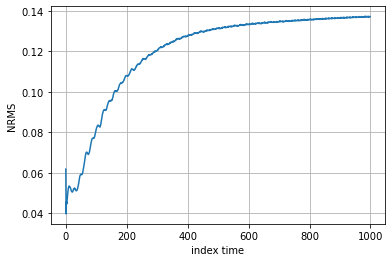

In [39]:
sys.n_step_error_plot(test[0], nf=1000,stride=10)

In [100]:
# train, test = deepSI.datasets.Silverbox()



# sys_LPV_single.init_model(sys_data=train)
# sys_LPV_single.apply_experiment(test[0][:10_000]).plot()
# torch.abs(torch.linalg.eigvals(sys_LPV_single.fn.As[0])), torch.abs(torch.linalg.eigvals(sys_LPV_single.fn.A)) #its nost unstable in 

In [112]:
# sys_LPV_single = LPV_single_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10)) #LPV_single_encoder(nx=8, na=5, nb=5)
# sys_LPV_single.checkpoint_load_system('_last')
sys_LPV_single.fit(train, test, epochs=100000, loss_kwargs=dict(nf=60), concurrent_val=True)#, optimizer_kwargs=dict(lr=0.0001))

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch    1, sqrt loss 0.07409, Val sim-NRMS  0.057, Time Loss: 99.7%, data: 0.3%, val: 0.0%,  0.0 vals/epoch,  6.4 batches/sec
Epoch    2, sqrt loss  0.1531, Val sim-NRMS  0.057, Time Loss: 99.7%, data: 0.2%, val: 0.0%,  0.0 vals/epoch,  6.4 batches/sec
Epoch    3, sqrt loss 0.04811, Val sim-NRMS  0.057, Time Loss: 99.6%, data: 0.2%, val: 0.1%,  3.0 epochs/val,  6.2 batches/sec
Epoch    4, sqrt loss 0.04267, Val sim-NRMS  0.057, Time Loss: 99.6%, data: 0.3%, val: 0.1%,  4.0 epochs/val,  6.3 batches/sec
Epoch    5, sqrt loss 0.04043, Val sim-NRMS 0.1336, Time Loss: 99.6%, data: 0.2%, val: 0.1%,  2.5 epochs/val,  6.2 batches/sec
Epoch    6, sqrt loss 0.04042, Val sim-NRMS 0.1336, Time Loss: 99.6%, data: 0.2%, val: 0.1%,  3.0 epochs/val,  6.2 batches/sec
Epoch    7, sqrt loss  0.1178, Val sim-NRMS 0.1195, Time Loss: 99.6%, data: 0.2%, val: 0.1%, 2.33 epochs/val,  6.2 batches/sec
Epoch    8, sqrt loss 0.07044, Val sim-NRMS 0.1195, Time Loss: 99.6%, data: 0.2%, val: 0.1%, 2.67 epochs/val,  

In [113]:
sys_LPV_single.save_system('sys_LPV_single-nx-5-Np-3-nf-60')

In [25]:
# sys.checkpoint_load_system('_last')
#todo's
# 1. Start fitting and get a result below 
#F=100 unstable after 3 epochs???
#F=1000 also unstable? Np from 3 -> 1, nope
# nx from 6 to 5? nope?
# is A unstable to begin with? No? lower learning rate from 0.0005 to 0.0001? Unstable region of training?
# lr=0.00005 seems stable? at nx=6, Np=3
# lr = 0.000075 also stable?
# lr = 0.0001 is unstable?
# is it a data property -> Check Silverbox?
# lower nf initially? Yes!, I don't know why it is so unstable to begin with. 

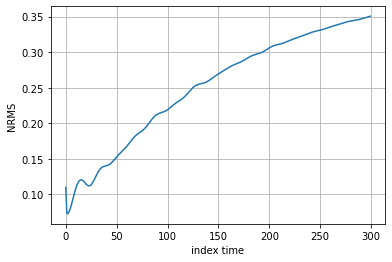